# TODO
- probar en Multi poner la length de la secuencia y su representcion num de la especie (no hacer onehot)
- incluir la validacion que usan en una discusion para esta competi
- pooling metodos https://www.kaggle.com/code/daehunbae/esm-2-3b-embeddings-with-three-pooling-methods/notebook

In [1]:
import pandas as pd
sub = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv", sep= "\t", header = None)
sub.columns = ["The Protein ID", "The Gene Ontology term (GO) ID", "Predicted link probability that GO appear in Protein"]
sub.head(5)

,The Protein ID,The Gene Ontology term (GO) ID,Predicted link probability that GO appear in Protein
0,A0A0A0MRZ7,GO:0000001,0.123
1,A0A0A0MRZ7,GO:0000002,0.123
2,A0A0A0MRZ8,GO:0000001,0.123
3,A0A0A0MRZ8,GO:0000002,0.123
4,A0A0A0MRZ9,GO:0000001,0.123


The evaluation metric used in this competition is the weighted F-measure, which combines precision and recall, taking into account the hierarchical structure of the Gene Ontology (GO). The formula for calculating the weighted F-measure is as follows:

$Weighted \ F-measure = \frac{(1 + β^2) * (weighted \ precision * weighted recall)}{((β^2 * weighted \ precision) + weighted \ recall)}$

where:
- β is a parameter that controls the trade-off between precision and recall. In this competition, β is set to 1, resulting in an equal weighting of precision and recall.
- Weighted precision is the precision score, considering the weights of the predicted terms. It is calculated as the sum of the products of the predicted term's weight and its true positive count, divided by the sum of the weights of all predicted terms.
- Weighted recall is the recall score, considering the weights of the true positive terms. It is calculated as the sum of the products of the true positive term's weight and its count, divided by the sum of the weights of all true positive terms.

Note: The specific formulas for weighted precision and weighted recall are provided in the competition materials and utilize additional information such as term weights and true positive counts.

# General Baseline in this Notebook

- **1 - Collect Embedding vectors from pre-trained protein function prediction models (T5, ProtBERT or EMS2) :**

Sources for embeddings vectors : 
- *T5* : https://www.kaggle.com/datasets/sergeifironov/t5embeds

- *ProtBERT* : https://www.kaggle.com/datasets/henriupton/protbert-embeddings-for-cafa5

- *EMS2* : https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-ems-2-embeddings-numpy

- **2 - Generate labels from train_terms file** : by considering the top K most common GO terms in all Proteins set, generate for each protein a sparse vector of length K to indicate the true probabilities that each of the K GO terms are in the Protein (0 or 1). Here we retain K = 600

- **3 - Create Pytorch Dataset class that can handle Protein ID and embeddings**.

- **4 - Create Pytorch Model class for prediction** : can be any architecture of Multilabel classification model that can turn embeddings of shape (E,) to probabilities of shape (K,). Here we explore **MultiLayerPerceptron** and **ConvNN1d** Networks.

- **5 - Make Cross Validation w.r.t the F-1 measure and do Hyperparameter tuning thanks to Weights and Biases package (Wandb)**

![baseline-image](https://www.researchgate.net/publication/334642149/figure/fig1/AS:783995214249986@1563930433525/Flow-chart-of-STRING2GO-based-protein-function-prediction-method.png)

## **Flow-chart of STRING2GO-based protein function prediction method**

# 1. Imports / Config

In [2]:
MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"
seed = 54

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import gc
import multiprocessing as mp
import copy
import logging
import pickle
from Bio import SeqIO
import re


# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy
from torch.utils.data import Subset
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import random
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# WANDB FOR LIGHTNING :
import wandb

# FILES VISUALIZATION
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/4637427/test_ids_esm2_t36_3B_UR50D.npy
/kaggle/input/4637427/train_ids_esm2_t36_3B_UR50D.npy
/kaggle/input/4637427/test_embeds_esm2_t36_3B_UR50D.npy
/kaggle/input/4637427/train_embeds_esm2_t36_3B_UR50D.npy
/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/PCA-2000_id13_DROP-0.15_model_CV-543674_186.74_0.13_0.53530.pth
/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/PCA-2000_id12_DROP-0.15_model_CV-531431_176.58_0.12_0.53830.pth
/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/pca_id12.pkl
/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/PCA-2000_id11_DROP-0.15_model_CV-538899_187.91_0.12_0.53013.pth
/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/pca_id11.pkl
/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/pca_id13.pkl
/kaggle/input/cafa5-best-models-3000labels/model_CV-526716_176.19_0.09_0.53544.pth
/kaggle/input/cafa5-best-models-3000labels/model_CV-534435_202.72_0.1_0.53772.pth
/kaggle/input/cafa5-best

In [3]:
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test (Targets)/testsuperset.fasta"
    
    set_seed = True # para comparar modelos con una seed fija en el train_split
    
    modo = 'scoring' # pesosCV, pesosLB, media, scoring (añadir valores, https://www.kaggle.com/code/mtinti/merge-datasets)
    filtrar = True
    filtrar_mode = 'normal' #diff es abs(cv -lb), normal es coger el LB, ambos es aplciar ambos IFs a la vez
    filtro = 0.54
    filtro_diff = 0.01
    
    embedding_a_usar = "EMS2_t36" #EMS2_t36
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# se me escapó una batch en el init que luego no se usa en el modelo en forward
# self.layer_norm = nn.BatchNorm1d(hidden_size)
IN_BATCH_WITHOUT_BATCH = ['PCA_id14_DROP-0.15_model_CV-536126_191.66_0.11_0.54227.pth',
                         'PCA-3KHIDDEN_id15_DROP-0.15_model_CV-552157_189.84_0.13_0.55307.pth',
                         'PCA-3KHIDDEN_id16_DROP-015_model_CV-560499_173.66_0.14_0.53784.pth',
                         'PCA-3KHIDDEN_id17_DROP-0.15_model_CV-563086_187.92_0.14_0.54998.pth']

In [4]:
print(config.device)

cpu


In [5]:
def extract_go_terms_and_branches(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        # Match each stanza with [Term] in the OBO file
        stanzas = re.findall(r'\[Term\][\s\S]*?(?=\n\[|$)', content)

    go_terms_dict = {}
    for stanza in stanzas:
        # Extract the GO term ID
        go_id = re.search(r'^id: (GO:\d+)', stanza, re.MULTILINE)
        if go_id:
            go_id = go_id.group(1)

        # Extract the namespace (branch)
        namespace = re.search(r'^namespace: (\w+)', stanza, re.MULTILINE)
        if namespace:
            namespace = namespace.group(1)

        if go_id and namespace:
            # Map the branch abbreviation to the corresponding BPO, CCO, or MFO
            branch_abbr = {'biological_process': 'BPO', 'cellular_component': 'CCO', 'molecular_function': 'MFO'}
            go_terms_dict[go_id] = branch_abbr[namespace]

    return go_terms_dict

file_path = '/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo'
go_terms_dict = extract_go_terms_and_branches(file_path)

In [6]:
# Define a class to manage predictions for proteins.
# The class keeps track of the highest score for each GO (Gene Ontology) term prediction.
# Note: This assumes scores are comparable, which might not be the case.
# A ranking-based selection could be more suitable.
# Each branch outputs a maximum of 35 predictions for each protein after sorting predictions from highest to lowest.
# There is an option to add a bonus to the score if the term is predicted by multiple methods.

class ProteinPredictions:
    # Initialize an empty dictionary to store the predictions
    def __init__(self):
        self.predictions = {}

    # Add a prediction to the storage, with optional bonus
    # Arguments:
    #   - protein: Identifier for the protein
    #   - go_term: GO term that is being predicted
    #   - score: Confidence score of the prediction
    #   - branch: Branch of the Gene Ontology (e.g., 'CCO', 'MFO', 'BPO')
    #   - bonus: Optional bonus to be added to the score
    def add_prediction(self, protein, go_term, score, branch, bonus=0):
        # If the protein is not already in the storage, initialize its structure
        if protein not in self.predictions:
            self.predictions[protein] = {'CCO': {}, 'MFO': {}, 'BPO': {}}
        
        # Convert the score to a float for comparison and calculation
        score = float(score)

        # If this GO term has already been predicted for this protein and branch,
        # add the bonus to the score. Keep the highest score.
        if go_term in self.predictions[protein][branch]:
            if self.predictions[protein][branch][go_term] < score:
                self.predictions[protein][branch][go_term] = score + bonus
            else:
                self.predictions[protein][branch][go_term] += bonus
        # If this GO term has not been predicted yet, store it with the score
        else:
            self.predictions[protein][branch][go_term] = score

        # Ensure that the score does not exceed 1
        if self.predictions[protein][branch][go_term] > 1:
            self.predictions[protein][branch][go_term] = 1

    # Export the stored predictions to a file
    # Arguments:
    #   - output_file: File name for the exported predictions
    #   - top: Number of top predictions to export for each protein and branch
    def get_predictions(self, output_file='submission.tsv', top=-1):
        # Open the output file
        with open(output_file, 'w') as f:
            # Iterate through each protein and its branches
            for protein, branches in self.predictions.items():
                # For each branch, sort the GO terms by score in descending order and select the top ones
                for branch, go_terms in branches.items():
                    # Sort go_terms by score in descending order and take the top ones
                    top_go_terms = sorted(go_terms.items(), key=lambda x: x[1], reverse=True)[:top]
                    # Write each of the top predictions to the file
                    for go_term, score in top_go_terms:
                        f.write(f"{protein}\t{go_term}\t{score:.3f}\n")
                        
SCORING_MAKER = ProteinPredictions()

# Metricas https://www.kaggle.com/code/sergeifironov/validate-ridge/notebook

# 5. Pytorch Dataset Architecture

In [7]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "EMS2" : "cafa-5-ems-2-embeddings-numpy",
    "EMS2_t36": "4637427"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "EMS2" : 1280,
    "EMS2_t36": 2560
}

In [8]:
def apply_quick_go_sub(sub_path, viene_de_ensemble = False, formato = 'pkl'):
    if not viene_de_ensemble: # le pasamos el link directo de otro lado
        sub = pd.read_csv(sub_path, sep ="\t")
        sub.to_csv('submission.tsv', sep='\t', index=False, header=False)
    
    if formato == 'pkl':
        file = open('/kaggle/input/quick-go-annotation/all_dict.pkl', 'rb')
        go_ann = pickle.load(file)
    elif formato == 'tsv':
        file = pd.read_csv('/kaggle/input/quick-go-2022-03-02/quickgo.tsv', sep = '\t')
        go_ann = file[['uniprot', 'term']].groupby('uniprot')['term'].apply(list).to_dict()
    
    #https://www.kaggle.com/datasets/mtinti/quick-go-annotation
    with open('submission.tsv', 'a') as sub:
    #     sub = file.read()
        for temp_id in tqdm(go_ann.keys()):
            if len(go_ann[temp_id])>0:
                for go in go_ann[temp_id]:
                    line = [temp_id,go,'0.999']
                    line = '\t'.join(line)+'\n'
                    sub.write(line)  

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source, apply_PCA = False, pca = None):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
        if embeddings_source == "T5":
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
        if embeddings_source == "EMS2_t36":
            embeds = np.load("/kaggle/input/4637427/" + datatype + "_embeds_esm2_t36_3B_UR50D.npy")
            ids = np.load("/kaggle/input/4637427/" + datatype + "_ids_esm2_t36_3B_UR50D.npy")
            
            
        # reduce memory
#         embeds = reduce_mem_usage(pd.DataFrame(embeds)).values
        gc.collect()
        
        if apply_PCA:
            embeds = pca.transform(embeds)
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            print('Leyendo las labels ...')
            df_labels = pd.read_pickle(
                "/kaggle/input/cafa5-labels-2500/train_targets.pkl")
            self.df = self.df.merge(df_labels, on="EntryID")
            
#         self.df = self.df.iloc[0:1000]       
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            id = self.df.iloc[index]["EntryID"]
            return embed, targets, id
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id
        

# Models Architectures

In [11]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes, hidden_size = 1500, has_dropout = False, has_unused_batch = False):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, hidden_size)
        self.activation1 = torch.nn.ReLU()
        self.has_dropout = has_dropout
        if has_unused_batch:
            self.layer_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.15)
        self.linear3 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        if self.has_dropout:
            x = self.dropout(x)
        x = self.linear3(x)
        return x

# Make Predictions

# Recuento de todos los modelos

In [12]:
def pasa_filtro(cv, lb):
    if config.filtrar_mode == 'diff':
        if abs(cv-lb) > config.filtro_diff:
            print('modelo no pasa a la siguiente ronda')
            return False
        else:
            return True
    elif config.filtrar_mode == 'normal':
        if lb < config.filtro:
            print('modelo no pasa a la siguiente ronda')
            return False
        else:
            return True
    elif config.filtrar_mode == 'ambos':
        if (abs(cv-lb) <= config.filtro_diff) and (lb >= config.filtro):
            return True
        else:
            print('modelo no pasa a la siguiente ronda')
            return False
    elif config.filtrar_mode == 'cv':
        if cv < config.filtro:
            print('modelo no pasa a la siguiente ronda')
            return False
        else:
            return True

In [13]:
total_lb = 0
total_cv = 0
total_models = 0
list_lb = []
list_cv = []
# 1. MODELOS CLASICOS
best_models_3000 = '/kaggle/input/cafa5-best-models-3000labels/'
# model_CV-XXXX_loss_acc_0.LB.pth
# for model_path in os.listdir(best_models_3000):
#     print(model_path)
#     lb = model_path.split('_')[-1]
#     lb = int(lb.split('.')[1])
#     cv = int(model_path.split('_')[1].split('-')[1])
#     # aplicamos el 0.
#     cv = float('0.' + str(cv))
#     lb = float('0.' + str(lb))
#     print('CV:', cv)
#     print('LB:', lb)
#     if config.filtrar:
#         bool_pasa_filtro = pasa_filtro(cv, lb)
#         if not bool_pasa_filtro:
#             continue
#     total_lb += lb
#     total_cv += cv
#     total_models += 1
#     list_lb.append(lb)
#     list_cv.append(cv)
    
    
# 2. MODELOS CLASICOS CON PCA 1500 
best_models_3000_PCA = '/kaggle/input/cafa5-best-pcamodels-3000labels/'
# PCA_idX_model_CV-XXXX_loss_acc_0.LB.pth
# for model_path in os.listdir(best_models_3000_PCA):
#     if model_path.endswith('.pth'):
#         print(model_path)
#         lb = model_path.split('_')[-1]
#         lb = int(lb.split('.')[1])
#         cv = int(model_path.split('_')[3].split('-')[1])
#         # aplicamos el 0.
#         cv = float('0.' + str(cv))
#         lb = float('0.' + str(lb))
#         print('CV:', cv)
#         print('LB:', lb)
#         if config.filtrar:
#             bool_pasa_filtro = pasa_filtro(cv, lb)
#             if not bool_pasa_filtro:
#                 continue
#         total_lb += lb
#         total_cv += cv
#         total_models += 1
#         list_lb.append(lb)
#         list_cv.append(cv)
        
# 3. MODELOS CLASICOS CON PCA 1500 y DROPOUT DE 0.15
best_models_3000_PCA_dropout015 = '/kaggle/input/cafa5-best-pca1500-models-3000labels-drop-015/'
# PCA_idX_DROP-0.15_model_CV-XXXX_loss_acc_0.LB.pth
for model_path in os.listdir(best_models_3000_PCA_dropout015):
    if model_path.endswith('.pth'):
        print(model_path)
        lb = model_path.split('_')[-1]
        lb = int(lb.split('.')[1])
        cv = int(model_path.split('_')[4].split('-')[1])
        # aplicamos el 0.
        cv = float('0.' + str(cv))
        lb = float('0.' + str(lb))
        print('CV:', cv)
        print('LB:', lb)
        if config.filtrar:
            bool_pasa_filtro = pasa_filtro(cv, lb)
            if not bool_pasa_filtro:
                continue
        total_lb += lb
        total_cv += cv
        total_models += 1
        list_lb.append(lb)
        list_cv.append(cv)
    
# 4. MODELOS CLASICOS CON PCA 2000 y DROPOUT DE 0.15
best_models_3000_PCA2000_dropout015 = '/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/'
# PCA_idX_DROP-0.15_model_CV-XXXX_loss_acc_0.LB.pth
for model_path in os.listdir(best_models_3000_PCA2000_dropout015):
    if model_path.endswith('.pth'):
        print(model_path)
        lb = model_path.split('_')[-1]
        lb = int(lb.split('.')[1])
        cv = int(model_path.split('_')[4].split('-')[1])
        # aplicamos el 0.
        cv = float('0.' + str(cv))
        lb = float('0.' + str(lb))
        print('CV:', cv)
        print('LB:', lb)
        if config.filtrar:
            bool_pasa_filtro = pasa_filtro(cv, lb)
            if not bool_pasa_filtro:
                continue
        total_lb += lb
        total_cv += cv
        total_models += 1
        list_lb.append(lb)
        list_cv.append(cv)
        
# 5. MODELOS CLASICOS CON PCA 1500 y DROPOUT DE 0.15 3000 HIDDEN SIZE
best_models_3000_PCA15003KHIDDEN_dropout015 = '/kaggle/input/cafa5-best-pca1500-3kh-models-3000labels-drop-015/'
# PCA-3KHIDDEN_idX_DROP-0.15_model_CV-XXXX_loss_acc_0.LB.pth
for model_path in os.listdir(best_models_3000_PCA15003KHIDDEN_dropout015):
    if model_path.endswith('.pth'):
        print(model_path)
        lb = model_path.split('_')[-1]
        lb = int(lb.split('.')[1])
        cv = int(model_path.split('_')[4].split('-')[1])
        # aplicamos el 0.
        cv = float('0.' + str(cv))
        lb = float('0.' + str(lb))
        print('CV:', cv)
        print('LB:', lb)
        if config.filtrar:
            bool_pasa_filtro = pasa_filtro(cv, lb)
            if not bool_pasa_filtro:
                continue
        total_lb += lb
        total_cv += cv
        total_models += 1
        list_lb.append(lb)
        list_cv.append(cv)
        
# X. MODELOS CLASICOS T5
# best_models_3000_T5 = '/kaggle/input/cafa5-best-models-t5-3000labels'
# # T5_model_CV-XXXX_loss_acc.pth
# for model_path in os.listdir(best_models_3000_T5):
#     print(model_path)
#     cv = int(model_path.split('_')[2].split('-')[1])
#     print('CV:', cv)
#     total_lb += cv
#     total_cv += cv
#     total_models += 1

print('Total models: ', total_models)
print('Media CV: ', round(total_cv / total_models, 5))
print('Media LB: ', round(total_lb / total_models, 5))

PCA_id5_DROP-0.15_model_CV-542653_183.61_0.12_0.52421.pth
CV: 0.542653
LB: 0.52421
modelo no pasa a la siguiente ronda
PCA_id9_DROP-0.15_model_CV-543757_181.42_0.13_0.53389.pth
CV: 0.543757
LB: 0.53389
modelo no pasa a la siguiente ronda
PCA_id4_DROP-0.15_model_CV-537197_186.06_0.12_0.53862.pth
CV: 0.537197
LB: 0.53862
modelo no pasa a la siguiente ronda
PCA_id7_DROP-0.15_model_CV-532444_184.26_0.12_0.52821.pth
CV: 0.532444
LB: 0.52821
modelo no pasa a la siguiente ronda
PCA_id10_DROP-0.15_model_CV-537342_192.19_0.11_0.53984.pth
CV: 0.537342
LB: 0.53984
modelo no pasa a la siguiente ronda
PCA_id6_DROP-0.15_model_CV-537538_194.95_0.12_0.52874.pth
CV: 0.537538
LB: 0.52874
modelo no pasa a la siguiente ronda
PCA_id14_DROP-0.15_model_CV-536126_191.66_0.11_0.54227.pth
CV: 0.536126
LB: 0.54227
PCA-2000_id13_DROP-0.15_model_CV-543674_186.74_0.13_0.53530.pth
CV: 0.543674
LB: 0.5353
modelo no pasa a la siguiente ronda
PCA-2000_id12_DROP-0.15_model_CV-531431_176.58_0.12_0.53830.pth
CV: 0.531431


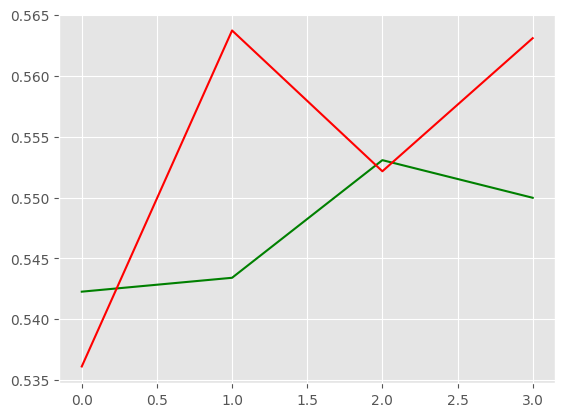

In [14]:
plt.plot(list_lb, 'g', list_cv, 'r')
plt.show()

In [15]:
final_labels_shape = 3000
count_totals = total_models

In [16]:
class preds_maker():
    
    def __init__(self, total_models, total_cv, total_lb):
        self.final_labels_shape = 3000
        self.count_totals = total_models
        self.total_cv = total_cv
        self.total_lb = total_lb
        self.labels = pd.read_csv(config.train_labels_path, sep = "\t")
        self.top_terms = self.labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
        self.labels_names = self.top_terms[:self.final_labels_shape].index.values
        print("GENERATE PREDICTION FOR TEST SET...")

        self.ids_ = np.empty(shape=(141865*self.final_labels_shape,), dtype=object)
        self.go_terms_ = np.empty(shape=(141865*self.final_labels_shape,), dtype=object)
        self.confs_ = np.zeros(shape=(141865*self.final_labels_shape,), dtype=np.float32)
        
    def cv_reader(self, path):
        cv = int(path.split('_')[-4].split('-')[1])
        cv = float('0.' + str(cv))
        print('CV es ', cv)
        return cv

    def lb_reader(self, path):
        lb = path.split('_')[-1]
        lb = int(lb.split('.')[1])
        lb = float('0.' + str(lb))
        print('LB es ', lb)
        return lb
    
    def id_reader(self, path):
        id = path.split('_')[1].split('.')[0]
        print(id)
        return id
    
    def make_preds_for_model_dataset(self, path_dataset, is_pca = False, pca_size = 1500, has_dropout = False, dropout = 0.15, hidden_size = 1500):
        print(path_dataset)
        for model_path in os.listdir(path_dataset):
            if model_path.endswith('.pth'):
                ### STATS
                print(model_path)
                # CV
                cv = self.cv_reader(model_path)
                peso_cv = cv / self.total_cv
                print('Peso CV: ', peso_cv)
                # LB
                lb = self.lb_reader(model_path)
                peso_lb = lb / self.total_lb
                print('Peso LB: ', peso_lb)
                # saltamos si no cumple el filtro
                if config.filtrar:
                    bool_pasa_filtro = pasa_filtro(cv, lb)
                    if not bool_pasa_filtro:
                        continue
                # cargamos su pca
                if is_pca:
                    id = self.id_reader(model_path)
                    with open(path_dataset + 'pca_' + id + '.pkl', 'rb') as pickle_file:
                        pca_loaded = pickle.load(pickle_file)

                else:
                    pca_loaded = None
     
                ### DATA PREPARATION
                test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = config.embedding_a_usar, apply_PCA = is_pca, pca = pca_loaded)
                test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

                ### MODEL PREPARATION
                if is_pca:
                    # layers MLP
                    input_dim = pca_size # 1500, 2000, ...
                else:
                    input_dim = 2560 # TODO pasar en funcion del embedding

                # por error, metí un batch que no se usa
                if model_path in IN_BATCH_WITHOUT_BATCH:
                    has_unused_batch = True
                else:
                    has_unused_batch = False
                model = MultiLayerPerceptron(input_dim, 3000, has_dropout = has_dropout, has_unused_batch = has_unused_batch, hidden_size = hidden_size)
                model.load_state_dict(torch.load(path_dataset + model_path))

                model.eval()

                model_confs_ = np.empty(shape=(len(test_dataloader)*self.final_labels_shape,), dtype=np.float32)
                self.count_totals -= 1

                ### PREDICTIONS
                for i, (embed, id) in tqdm(enumerate(test_dataloader)):
                    embed = embed.to(config.device)
                    model_confs_[i*self.final_labels_shape:(i+1)*self.final_labels_shape] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()[:final_labels_shape]
                    if (config.modo == 'scoring') or (self.count_totals == 0): # solo guardo si es scoring o se ha llegado al ultimo modelo
                        self.ids_[i*self.final_labels_shape:(i+1)*self.final_labels_shape] = id[0]
                        self.go_terms_[i*self.final_labels_shape:(i+1)*self.final_labels_shape] = self.labels_names
                    else:
                        continue

                ### PREDICTIONS POST-PROCESSING
                if config.modo == 'pesosCV':
                    self.confs_ += (model_confs_ * peso_cv)
                elif config.modo == 'pesosLB':
                    self.confs_ += (model_confs_ * peso_lb)
                elif config.modo == 'media':
                    self.confs_ += model_confs_
                elif config.modo == 'scoring':
                    filtered_model_confs_ = model_confs_#[model_confs_ > 0.3]
                    for i in tqdm(range(0, len(filtered_model_confs_))):
                        temp_id = self.ids_[i]
                        go = self.go_terms_[i]
                        score = filtered_model_confs_[i]
                        if score > 0.3 and go in go_terms_dict:
                            root = go_terms_dict[go]
                            SCORING_MAKER.add_prediction(temp_id, go, score, root)

                del test_dataset, test_dataloader, model
                gc.collect()    

In [17]:
%%time

MAKER = preds_maker(total_models, total_cv, total_lb)

GENERATE PREDICTION FOR TEST SET...
CPU times: user 5.62 s, sys: 4.85 s, total: 10.5 s
Wall time: 11.4 s


### 1. MODELOS CLASICOS

In [18]:
%%time
# MAKER.make_preds_for_model_dataset(best_models_3000)

gc.collect()

CPU times: user 339 ms, sys: 1.04 ms, total: 340 ms
Wall time: 338 ms


6897

### 2. MODELOS CLASICOS CON PCA 1500 

In [19]:

# MAKER.make_preds_for_model_dataset(best_models_3000_PCA, is_pca = True)

gc.collect()

0

### 3. MODELOS CLASICOS CON PCA 1500 y DROPOUT de 0.15

In [20]:
MAKER.make_preds_for_model_dataset(best_models_3000_PCA_dropout015, is_pca = True, has_dropout = True)

gc.collect()

/kaggle/input/cafa5-best-pca1500-models-3000labels-drop-015/
PCA_id5_DROP-0.15_model_CV-542653_183.61_0.12_0.52421.pth
CV es  0.542653
Peso CV:  0.24498033486705725
LB es  0.52421
Peso LB:  0.2395041873597931
modelo no pasa a la siguiente ronda
PCA_id9_DROP-0.15_model_CV-543757_181.42_0.13_0.53389.pth
CV es  0.543757
Peso CV:  0.2454787349306213
LB es  0.53389
Peso LB:  0.24392684342061377
modelo no pasa a la siguiente ronda
PCA_id4_DROP-0.15_model_CV-537197_186.06_0.12_0.53862.pth
CV es  0.537197
Peso CV:  0.24251722730654499
LB es  0.53862
Peso LB:  0.2460879139957875
modelo no pasa a la siguiente ronda
PCA_id7_DROP-0.15_model_CV-532444_184.26_0.12_0.52821.pth
CV es  0.532444
Peso CV:  0.24037148862708846
LB es  0.52821
Peso LB:  0.2413317311865785
modelo no pasa a la siguiente ronda
PCA_id10_DROP-0.15_model_CV-537342_192.19_0.11_0.53984.pth
CV es  0.537342
Peso CV:  0.24258268745982103
LB es  0.53984
Peso LB:  0.24664531486295704
modelo no pasa a la siguiente ronda
PCA_id6_DROP-0.15

141865it [04:09, 567.83it/s]
100%|██████████| 425595000/425595000 [31:32<00:00, 224937.50it/s]


0

### 4. MODELOS CLASICOS CON PCA 2000 y DROPOUT de 0.15

In [21]:
MAKER.make_preds_for_model_dataset(best_models_3000_PCA2000_dropout015, is_pca = True, pca_size = 2000, has_dropout = True)

gc.collect()

/kaggle/input/cafa5-best-pca2000-models-3000labels-drop-015/
PCA-2000_id13_DROP-0.15_model_CV-543674_186.74_0.13_0.53530.pth
CV es  0.543674
Peso CV:  0.2454412646359874
LB es  0.5353
Peso LB:  0.2445710526195556
modelo no pasa a la siguiente ronda
PCA-2000_id12_DROP-0.15_model_CV-531431_176.58_0.12_0.53830.pth
CV es  0.531431
Peso CV:  0.23991417045282176
LB es  0.5383
Peso LB:  0.24594171048964467
modelo no pasa a la siguiente ronda
PCA-2000_id11_DROP-0.15_model_CV-538899_187.91_0.12_0.53013.pth
CV es  0.538899
Peso CV:  0.24328559407120623
LB es  0.53013
Peso LB:  0.2422089522234355
modelo no pasa a la siguiente ronda


0

### 5. MODELOS CLASICOS CON PCA 1500 y DROPOUT de 0.15 y 3000 de HIDDEN SIZE

In [22]:
MAKER.make_preds_for_model_dataset(best_models_3000_PCA15003KHIDDEN_dropout015, is_pca = True, has_dropout = True, hidden_size = 3000)

gc.collect()

/kaggle/input/cafa5-best-pca1500-3kh-models-3000labels-drop-015/
PCA-3KHIDDEN_id19_DROP-0.15_model_CV-556272_173.86_0.13_0.53556.pth
CV es  0.556272
Peso CV:  0.2511286233323462
LB es  0.53556
Peso LB:  0.24468984296829668
modelo no pasa a la siguiente ronda
PCA-3KHIDDEN_id20_DROP-0.15_model_CV-563719_194.55_0.16_0.54341.pth
CV es  0.563719
Peso CV:  0.25449056651473895
LB es  0.54341
Peso LB:  0.248276397728363
id20


141865it [07:43, 306.21it/s]
100%|██████████| 425595000/425595000 [31:08<00:00, 227783.22it/s]


PCA-3KHIDDEN_id15_DROP-0.15_model_CV-552157_189.84_0.13_0.55307.pth
CV es  0.552157
Peso CV:  0.24927090932730442
LB es  0.55307
Peso LB:  0.2526899160700497
id15


141865it [07:55, 298.11it/s]
100%|██████████| 425595000/425595000 [31:44<00:00, 223422.78it/s]


PCA-3KHIDDEN_id22_DROP-0.15_model_CV-558764_197.27_0.15_0.53877.pth
CV es  0.558764
Peso CV:  0.25225363507002885
LB es  0.53877
Peso LB:  0.24615644688929195
modelo no pasa a la siguiente ronda
PCA-3KHIDDEN_id16_DROP-015_model_CV-560499_173.66_0.14_0.53784.pth
CV es  0.560499
Peso CV:  0.25303689966267706
LB es  0.53784
Peso LB:  0.24573154294956434
modelo no pasa a la siguiente ronda
PCA-3KHIDDEN_id18_DROP-0.15_model_CV-556172_177.57_0.13_0.53962.pth
CV es  0.556172
Peso CV:  0.2510834783990524
LB es  0.53962
Peso LB:  0.24654479995248385
modelo no pasa a la siguiente ronda
PCA-3KHIDDEN_id21_DROP-0.15_model_CV-569379_178.92_0.15_0.53782.pth
CV es  0.569379
Peso CV:  0.25704576973917065
LB es  0.53782
Peso LB:  0.2457224052304304
modelo no pasa a la siguiente ronda
PCA-3KHIDDEN_id17_DROP-0.15_model_CV-563086_187.92_0.14_0.54998.pth
CV es  0.563086
Peso CV:  0.2542047990869889
LB es  0.54998
Peso LB:  0.25127813846385805
id17


141865it [07:54, 299.22it/s]
100%|██████████| 425595000/425595000 [31:16<00:00, 226785.60it/s]


0

# CREAMOS SUBMISSION

In [23]:
if config.modo == 'media':
    confs_ = (MAKER.confs_ / total_models)
elif config.modo == 'scoring':
    SCORING_MAKER.get_predictions()
else:
    confs_ = MAKER.confs_

In [24]:
if config.modo != 'scoring':
    submission_df = pd.DataFrame(data={"Id" : MAKER.ids_, "GO term" : MAKER.go_terms_, "Confidence" : confs_})
    print(submission_df.head(50))
    print(submission_df.shape)
    # filtracion
    submission_df = submission_df[submission_df.Confidence >= 0.3]
    print(submission_df.shape)
    print('A .tsv')
    submission_df.to_csv('submission.tsv', sep='\t', index=False)

In [25]:
apply_quick_go_sub('/kaggle/working/submission.tsv', viene_de_ensemble = True)

100%|██████████| 210457/210457 [00:02<00:00, 90373.71it/s]
